## Compact Convolutional Transformer
Training and definition of the supervised classifier baseline:
* https://keras.io/examples/vision/cct/

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow_addons.optimizers import AdamW

In [2]:
import ad

from ad import utils
from ad.models import get_cct

In [3]:
utils.set_random_seed(42)
ad.plot.set_style(default_cmap=ad.plot.CMAP2)

Random seed 42 set.


In [4]:
%load_ext autoreload
%autoreload 2

Training data

In [5]:
qcd1 = utils.read_npz(folder='data/supervised/train', dtype=np.float32,
                      keep='qcd', verbose=False,
                      shuffle=True, keys=['images', 'labels', 'masses'])

qcd2 = utils.read_npz(folder='data/supervised/valid', dtype=np.float32,
                      keep='qcd', verbose=False,
                      shuffle=True, keys=['images', 'labels', 'masses'])

suep = utils.read_npz(folder='data/supervised/valid', dtype=np.float32,
                      keep='suep', verbose=False,
                      shuffle=True, keys=['images', 'labels', 'masses'])

svj = utils.read_npz(folder='data/supervised/valid', dtype=np.float32,
                     keep='svj', verbose=False,
                     shuffle=True, keys=['images', 'labels', 'masses'])

In [6]:
x_data = np.concatenate([qcd1['images'], qcd2['images'], suep['images'], svj['images']])
x_data = ad.constants.clip(x_data)

y_data = np.concatenate([qcd1['labels'], qcd2['labels'], suep['labels'], svj['labels']])
y_data = tf.keras.utils.to_categorical(y_data)

m_data = np.concatenate([qcd1['masses'], qcd2['masses'], suep['masses'], svj['masses']])

In [7]:
# train-valid split
from sklearn.model_selection import train_test_split

indices = np.arange(len(x_data))
train_idx, valid_idx = train_test_split(indices, test_size=0.2, stratify=y_data.argmax(-1),
                                        random_state=utils.SEED)

Training

In [8]:
model = get_cct(num_classes=3, input_shape=(72, 58, 1), num_heads=2,
                dropout=0.2, stochastic_depth_rate=0.2,
                projection_dim=128, transformer_units=[128, 128])
model.summary()

Model: "Compact-ViT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 58, 1)]  0           []                               
                                                                                                  
 data_aug (CCTDataAugmentation)  (None, 72, 58, 1)   0           ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 270, 128)     74304       ['data_aug[0][0]']               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 270, 128)    0           ['cct_tokenizer[0][0]']          
 da)                                                                                    

In [9]:
model.compile(optimizer=AdamW(weight_decay=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True,
                                                           label_smoothing=0.1),
              metrics=[ad.metrics.CategoricalAccuracy(True, name='accuracy'),
                       ad.metrics.AUC(True, name='auc'),
                       ad.metrics.Precision(True, name='precision'),
                       ad.metrics.Recall(True, name='recall')])

checkpoint = utils.get_checkpoint(path='supervised-cct',
                                  monitor='val_auc', mode='max', best_only=True)

In [10]:
h = model.fit(x=x_data[train_idx], y=y_data[train_idx], epochs=30, batch_size=128,
              validation_data=(x_data[valid_idx], y_data[valid_idx]), verbose=1,
              callbacks=[checkpoint])

Epoch 1/30
645/645 [==============================] - 242s 367ms/step - loss: 0.8089 - accuracy: 0.6711 - auc: 0.8521 - precision: 0.7166 - recall: 0.5766 - val_loss: 0.6497 - val_accuracy: 0.7877 - val_auc: 0.9362 - val_precision: 0.7952 - val_recall: 0.7771
Epoch 2/30
645/645 [==============================] - 354s 549ms/step - loss: 0.5374 - accuracy: 0.8545 - auc: 0.9637 - precision: 0.8651 - recall: 0.8421 - val_loss: 0.5450 - val_accuracy: 0.8630 - val_auc: 0.9654 - val_precision: 0.8720 - val_recall: 0.8515
Epoch 3/30
645/645 [==============================] - 388s 601ms/step - loss: 0.5059 - accuracy: 0.8753 - auc: 0.9718 - precision: 0.8840 - recall: 0.8654 - val_loss: 0.4879 - val_accuracy: 0.8925 - val_auc: 0.9789 - val_precision: 0.8979 - val_recall: 0.8866
Epoch 4/30
645/645 [==============================] - 385s 597ms/step - loss: 0.4827 - accuracy: 0.8902 - auc: 0.9771 - precision: 0.8976 - recall: 0.8815 - val_loss: 0.4826 - val_accuracy: 0.8994 - val_auc: 0.9793 - val

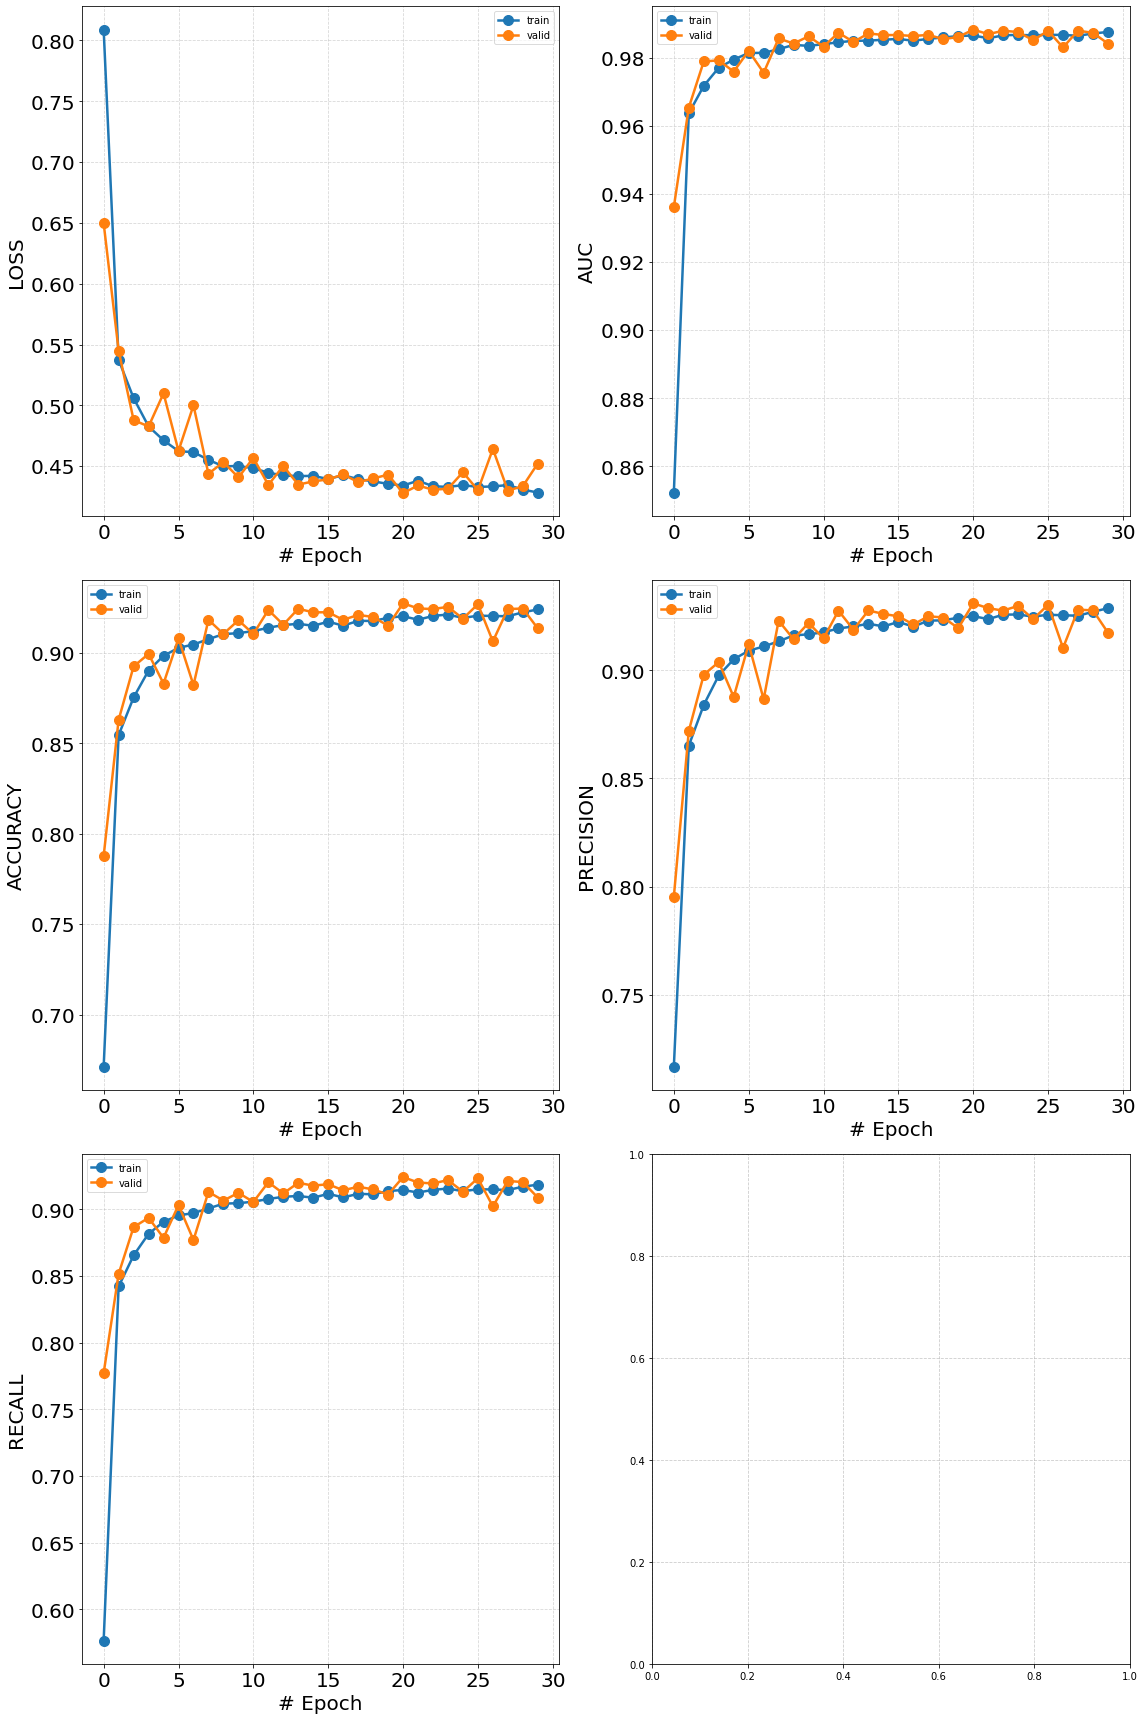

In [11]:
h = ad.plot.history(h, keys=['loss', 'auc', 'accuracy', 'precision', 'recall'],
                    rows=3)